Based on [this Kaggle kernel](https://www.kaggle.com/pablovargas/naive-bayes-svm-spam-filtering); [UCI SMS Spam Collection Data Set](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection)

#  Spam classification with Naive Bayes

- Libraries
- Exploring the Dataset
- Distribution spam and non-spam plots
- Text Analytics
- Feature Engineering
- Predictive analysis (**Multinomial Naive Bayes**)
- Conclusion

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
%matplotlib inline  

## Exploring the Dataset

In [2]:
data = pd.read_csv('spam.csv', encoding='latin-1')
data.head(10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


First we can see that there are 3 useless columns.

Let's check if third column are fully populated by NaNs

In [3]:
data.iloc[:, 2][~data.iloc[:, 2].isnull()]

95                                            PO Box 5249
281      the person is definitely special for u..... B...
444      HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE ...
671      wanted to say hi. HI!!!\" Stop? Send STOP to ...
710       this wont even start........ Datz confidence.."
899                                           PO Box 5249
1038                                                   GN
1127                                             .;-):-D"
1266    just been in bedbut mite go 2 thepub l8tr if u...
1384     bt not his girlfrnd... G o o d n i g h t . . .@"
1428                                        I'll come up"
1559     don't miss ur best life for anything... Gud n...
1637     just as a shop has to give a guarantee on wha...
1669     But at d end my love compromised me for every...
1675     the toughest is acting Happy with all unspoke...
1936                                  smoke hella weed\""
1937                       \" not \"what i need to do.\""
1997    JUST G

No, last columns are just missplitted by defauld Pandas parser cause messages contained ',' as a text

**TODO** write script that reads dataset correctly:

DataFrame of two columns `v1, v2` for type and content of message respectively, without loosing last parts of some messages

In [4]:
# Your code here

## Distribution spam/non-spam plots

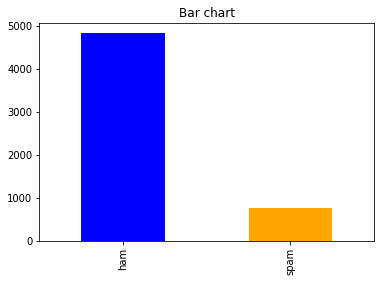

In [5]:
count_class = pd.value_counts(data["v1"], sort=True)
count_class.plot(kind='bar', color=["blue", "orange"])
plt.title('Bar chart')
plt.show()

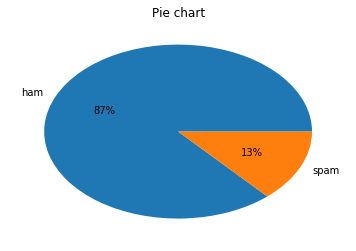

In [6]:
count_class.plot(kind='pie', autopct='%1.0f%%')
plt.title('Pie chart')
plt.ylabel('')
plt.show()

## Text Analytics

We want to find the frequencies of words in the spam and non-spam messages. The words of the messages will be model features.<p>
We use the function Counter.

In [7]:
count1 = Counter(" ".join(data[data['v1']=='ham']["v2"]).split()).most_common(20)
df1 = pd.DataFrame.from_dict(count1)
df1 = df1.rename(columns={0: "words in non-spam", 1 : "count"})
count2 = Counter(" ".join(data[data['v1']=='spam']["v2"]).split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)
df2 = df2.rename(columns={0: "words in spam", 1 : "count_"})

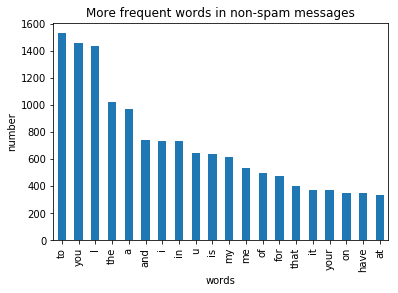

In [8]:
df1.plot.bar(legend = False)
y_pos = np.arange(len(df1["words in non-spam"]))
plt.xticks(y_pos, df1["words in non-spam"])
plt.title('More frequent words in non-spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

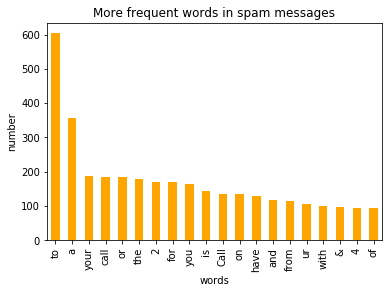

In [9]:
df2.plot.bar(legend = False, color = 'orange')
y_pos = np.arange(len(df2["words in spam"]))
plt.xticks(y_pos, df2["words in spam"])
plt.title('More frequent words in spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

We can see that the majority of frequent words in both classes are stop words such as 'to', 'a', 'or' and so on. <p>
With stop words we refer to the most common words in a lenguage, there is no simgle, universal list of stop words. <p>

## Feature engineering

Text preprocessing, tokenizing and filtering of stopwords are included in a high level component that is able to build a dictionary of features and transform documents to feature vectors.<p>
**We remove the stop words in order to improve the analytics**

In [10]:
f = feature_extraction.text.CountVectorizer(stop_words='english')
X = f.fit_transform(data["v2"])
np.shape(X)

(5572, 8404)

We have created more than 8400 new features. The new feature $j$ in the row $i$ is equal to 1 if the word $w_{j}$ appears in the text example $i$. It is zero if not.

## Predictive Analysis

**Our goal is to predict if a new sms is spam or non-spam. We assume that is much worse misclassify non-spam than misclassify an spam. (We don't want to have false positives)**
<p>
The reason is because we normally don't check the spam messages.<p> The two possible situations are:<p>
1. New spam sms in my inbox. (False negative).<p>
OUTCOME: I delete it.<p>
2. New non-spam sms in my spam folder (False positive).<p>  OUTCOME: I probably don't read it. <p>
I prefer the first option!!!

First we transform the variable spam/non-spam into binary variable, then we split our data set in training set and test set. 

In [11]:
data["v1"] = data["v1"].map({'spam': 1,'ham': 0})
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, data['v1'], test_size=0.33, random_state=42)
print([np.shape(X_train), np.shape(X_test)])

[(3733, 8404), (1839, 8404)]


### Multinomial naive bayes classifier

We train different bayes models changing the regularization parameter $\alpha$. <p>
We evaluate the accuracy, recall and precision of the model with the test set.

**TODO** Perform gridsearch over `alpha` of `MultinomialNB`

then from models with highest precision choose the best one, which metric is worth optimizing in this case? Why?

_Tip_: try to use `GridsearchCV`'s parameter `scoring`, for details see [this](https://scikit-learn.org/stable/modules/grid_search.html#multimetric-grid-search)

In [12]:
# Your code here

Display confusion matrix of naive bayes classifier

In [13]:
m_confusion_test = metrics.confusion_matrix(y_test, bayes.predict(X_test))
pd.DataFrame(
    data=m_confusion_test,
    columns=['Predicted Ham', 'Predicted Spam'],
    index =['Actual Ham', 'Actual Spam'],
)

NameError: name 'bayes' is not defined

Even such a simple model as Naive Bayes is able to solve precisely what kind of message do we have.

Why is it possible? Discuss your ideas.

P.S. [dedicated article](http://www2.aueb.gr/users/ion/docs/ceas2006_paper.pdf)